In [5]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import sys
sys.path.append('../examples')
sys.path.append('../jobs')
sys.path.append('../training_data')

from tqdm import trange

import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from generate_with_calibration import get_lookahead_entropies
from generate_with_entropy import sample_sequence, sample_sequence_batch, top_k_top_p_filtering

import logging
logging.getLogger('transformers.tokenization_utils').setLevel(logging.ERROR)

In [6]:
# setup cell

def set_seed(seed=42, n_gpu=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpus = torch.cuda.device_count()

set_seed()
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.to(device)
model.eval()

vocab_size = tokenizer.vocab_size

01/11/2020 11:52:55 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json from cache at /u/myhu/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.085d5f6a8e7812ea05ff0e6ed0645ab2e75d80387ad55c1ad9806ee70d272f80
01/11/2020 11:52:55 - INFO - transformers.configuration_utils -   Model config {
  "attn_pdrop": 0.1,
  "embd_pdrop": 0.1,
  "finetuning_task": null,
  "initializer_range": 0.02,
  "is_decoder": false,
  "layer_norm_epsilon": 1e-05,
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_labels": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "torchscript": false,
  "use_bf

In [7]:
def calibrated_generation(file, length=100, num_samples=1, temperature=1, top_k=0, top_p=0.0):
    ret = []
    with open(file) as fp:
        for line in fp:
            context = tokenizer.encode(line)
            context = torch.tensor(context, dtype=torch.long, device=device)
            context = context.unsqueeze(0).repeat(num_samples, 1)
            generated = context

            with torch.no_grad():

                for gen_index in trange(length):

                    inputs = {'input_ids': generated}

                    outputs = model(**inputs)
                    next_token_logits = outputs[0][:, -1, :] / temperature
                    next_probs = F.softmax(next_token_logits, dim=-1)[0].detach().cpu().numpy()

                    filtered_logits = top_k_top_p_filtering(next_token_logits, top_k=top_k, top_p=top_p)
                    next_token = torch.multinomial(F.softmax(filtered_logits, dim=-1), num_samples=1)
                    rank = np.argsort(next_probs)[::-1]
                    ret.append(np.argwhere(rank == next_token.item())[0][0]) # grossly inefficient but idc anymore

                    generated = torch.cat((generated, next_token), dim=1)
    return ret

In [8]:
inv_cdf = np.load('inv_cdf.npz')['inv_cdf']

In [9]:
test = gaussian_kde(inv_cdf)

In [14]:
context = "Models of Cognition is a great class."
length = 100

context = tokenizer.encode(context)
context = torch.tensor(context, dtype=torch.long, device=device)
context = context.unsqueeze(0).repeat(1, 1)
generated = context

def sample(kde):
    val = float('inf')
    while val > 1.0 or val < 0.0:
        val = kde.resample(1)[0][0]
    return val

with torch.no_grad():
    for _ in trange(length):
        inputs = {'input_ids': generated}

        outputs = model(**inputs)
        next_token_logits = outputs[0][:, -1, :]
        next_probs = F.softmax(next_token_logits, dim=-1)[0].detach().cpu().numpy()

        rank = np.argsort(next_probs)[::-1]
        cdf = np.cumsum(next_probs[rank])
        val = sample(test)

        vals = np.argwhere(cdf < val)
        if vals.size == 0:
            next_token_rank = 0
        else:
            next_token_rank = vals[-1][0]

        next_token = torch.tensor([rank[next_token_rank]], dtype=torch.long, device=device).unsqueeze(0)
        generated = torch.cat((generated, next_token), dim=1)

100%|██████████| 100/100 [00:02<00:00, 43.35it/s]


In [15]:
for j in range(len(generated)):
    seq = generated[j, len(context):].tolist()
    text = tokenizer.decode(seq, clean_up_tokenization_spaces=True)
    print(text)

els of Cognition is a great class. It's a great class for recognizing complex states of mind. I totally agree with Matthew Davies of the Oxford Journal of Psychology and Medical Neuroscience in stating that the brain is over the moon with attention training and intermuscular competition. He obviously has long known about the advantages of attention training because recall speed is crap or hyperreflexia doesn't work. The problem is that self-report test that is very similar to SAT/ED6 also does. Sheffield experts have best theory of mind call 9


In [17]:
def get_calibrated_counts(file, length=100, num_samples=1):
    ret = []
    with open(file) as fp:
        for line in fp:
            context = tokenizer.encode(line)
            context = torch.tensor(context, dtype=torch.long, device=device)
            context = context.unsqueeze(0).repeat(num_samples, 1)
            generated = context

            with torch.no_grad():

                for gen_index in trange(length):

                    inputs = {'input_ids': generated}

                    outputs = model(**inputs)
                    next_token_logits = outputs[0][:, -1, :]
                    next_probs = F.softmax(next_token_logits, dim=-1)[0].detach().cpu().numpy()

                    rank = np.argsort(next_probs)[::-1]
                    cdf = np.cumsum(next_probs[rank])
                    val = sample(test)

                    vals = np.argwhere(cdf < val)
                    if vals.size == 0:
                        next_token_rank = 0
                    else:
                        next_token_rank = vals[-1][0]
                    
                    ret.append(next_token_rank)
                    next_token = torch.tensor([rank[next_token_rank]], dtype=torch.long, device=device).unsqueeze(0)
                    generated = torch.cat((generated, next_token), dim=1)
    return ret

In [12]:
file = '../training_data/gbw/training/news1-head100'

In [18]:
counts_inv = get_calibrated_counts(file)

100%|██████████| 100/100 [00:02<00:00, 34.35it/s]


Text(0.5, 1.0, 'Inverse CDF method')

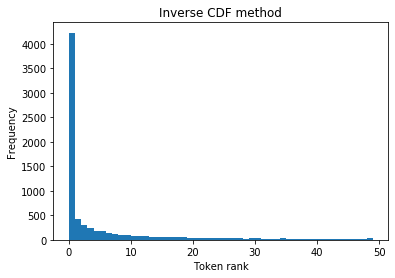

In [20]:
bins_2 = list(range(0, 50))
plt.hist(counts_inv, bins_2)
plt.xlabel('Token rank')
plt.ylabel('Frequency')
plt.title('Inverse CDF method')

In [30]:
np.savez('011020_inv_cdf_token_ranks', ranks=counts_inv)